In [255]:
import pandas as pd
import keras
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.io as spio
import sklearn.decomposition as dec
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
import sklearn.metrics.pairwise as pw

#get fft data from file
mat = spio.loadmat('label.mat',squeeze_me=True)
labels = mat['label'];

mat = spio.loadmat('freezeIndex.mat',squeeze_me=True)
freezeindex = mat['freezeIndex'];

mat = spio.loadmat('dominantF.mat',squeeze_me=True)
dominantF = mat['I'];

mat = spio.loadmat('neighbour_V.mat',squeeze_me=True)
neighbour_V = mat['sum_V'];

mat = spio.loadmat('portion_above.mat',squeeze_me=True)
portion_above = mat['pa'];

mat = spio.loadmat('mean.mat',squeeze_me=True)
means = mat['y_mean'];

print labels.shape
print means.shape
print freezeindex.shape
print dominantF.shape
print neighbour_V.shape
print portion_above.shape

(4742,)
(4742,)
(4742,)
(4742,)
(4742,)
(4742,)


In [256]:
#find the labels of FoG and noFoG
FoG = np.where(labels == 2)
noFoG = np.where(labels == 1)

filter_indices = noFoG
noFoG_labels = np.array(labels)[noFoG]
print noFoG_labels.shape

filter_indices = FoG
FoG_labels = np.array(labels)[FoG]
print FoG_labels.shape

(2741,)
(159,)


In [257]:
#find inputs of noFoG
noFoG_mean =  np.array(means)[noFoG]
noFoG_freezeindex =  np.array(freezeindex)[noFoG]
noFoG_dominantF = np.array(dominantF)[noFoG]
noFoG_neighbour_V = np.array(neighbour_V)[noFoG]
noFoG_portion_above = np.array(portion_above)[noFoG]

noFoG_input = np.stack([noFoG_mean,noFoG_freezeindex,noFoG_dominantF,noFoG_neighbour_V,noFoG_portion_above]).transpose()

print noFoG_input.shape

#find inputs of FoG
FoG_mean =  np.array(means)[FoG]
FoG_freezeindex =  np.array(freezeindex)[FoG]
FoG_dominantF = np.array(dominantF)[FoG]
FoG_neighbour_V = np.array(neighbour_V)[FoG]
FoG_portion_above = np.array(portion_above)[FoG]

FoG_input = np.stack([FoG_mean,FoG_freezeindex,FoG_dominantF,FoG_neighbour_V,FoG_portion_above]).transpose()

print FoG_input.shape

(2741, 5)
(159, 5)


((2741,), (2741, 5))


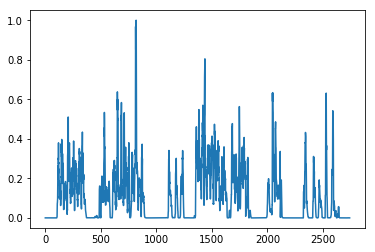

In [280]:
#normalization
noFoG_max = np.amax(noFoG_input,axis=0);
noFoG_min = np.amin(noFoG_input,axis=0);
noFoG_input = (noFoG_input-noFoG_min)/(noFoG_max-noFoG_min) 

FoG_max = np.amax(FoG_input,axis=0);
FoG_min = np.amin(FoG_input,axis=0);
FoG_input = (FoG_input-FoG_min)/(FoG_max-FoG_min)

x = np.arange(0,noFoG_labels.shape[0],1);
print(x.shape,noFoG_input.shape)
plt.plot(x, noFoG_input[:,3])

In [264]:
#distribute to groups
from sklearn.model_selection import train_test_split

#noFoG_input = noFoG_input[:500,:]
#noFoG_labels = noFoG_labels[:500]

X_train1,X_test1,y_train1,y_test1 = train_test_split(noFoG_input,noFoG_labels,test_size=0.2,random_state=4)
X_train2,X_test2,y_train2,y_test2 = train_test_split(FoG_input,FoG_labels,test_size=0.2,random_state=4)

print(X_train1.shape)
print(X_test1.shape)
print(X_train2.shape)
print(X_test2.shape)

X_train = np.concatenate((X_train1,X_train2))
y_train = np.concatenate((y_train1,y_train2))
X_test = np.concatenate((X_test1,X_test2))
y_test = np.concatenate((y_test1,y_test2))

print(X_train.shape)
print(X_test.shape)

(2192, 5)
(549, 5)
(127, 5)
(32, 5)
(2319, 5)
(581, 5)


In [260]:
#one hot encoding
num_classes = 2
y_train = keras.utils.to_categorical(y_train-1, num_classes)
y_test = keras.utils.to_categorical(y_test-1, num_classes)

In [261]:
from keras.layers import Dense
from keras.models import Sequential
input_size = 5
num_classes = 2
neuron2  =  20
model = Sequential()
model.add(Dense(neuron2, activation='sigmoid', input_shape=(input_size,)))
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 20)                120       
_________________________________________________________________
dense_66 (Dense)             (None, 2)                 42        
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________


In [262]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(X_test, y_test, verbose=False)
print(loss,accuracy)

Train on 2087 samples, validate on 232 samples
Epoch 1/10
2087/2087 [==============================] - 1s 520us/step - loss: 0.7715 - acc: 0.4006 - val_loss: 0.7367 - val_acc: 0.4526
Epoch 2/10
2087/2087 [==============================] - 0s 33us/step - loss: 0.3897 - acc: 1.0000 - val_loss: 0.8913 - val_acc: 0.4526
Epoch 3/10
2087/2087 [==============================] - 0s 47us/step - loss: 0.2408 - acc: 1.0000 - val_loss: 1.0426 - val_acc: 0.4526
Epoch 4/10
2087/2087 [==============================] - 0s 40us/step - loss: 0.1695 - acc: 1.0000 - val_loss: 1.1722 - val_acc: 0.4526
Epoch 5/10
2087/2087 [==============================] - 0s 53us/step - loss: 0.1293 - acc: 1.0000 - val_loss: 1.2820 - val_acc: 0.4526
Epoch 6/10
2087/2087 [==============================] - 0s 44us/step - loss: 0.1038 - acc: 1.0000 - val_loss: 1.3762 - val_acc: 0.4526
Epoch 7/10
2087/2087 [==============================] - 0s 42us/step - loss: 0.0865 - acc: 1.0000 - val_loss: 1.4582 - val_acc: 0.4526
Epoch 8

In [263]:
y_pred = model.predict_classes(X_test);
y_test = np.concatenate((y_test1,y_test2));
print y_pred
print y_test.shape

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [254]:
testy = y_test-1
yhat_classes = y_pred
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)

#precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes,average='macro')
print('Precision: %f' % precision)

#recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes,average='macro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes,average='macro')
print('F1 score: %f' % f1)

# confusion matrix
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)

Accuracy: 0.944923
Precision: 0.472461
Recall: 0.500000
F1 score: 0.485841
[[549   0]
 [ 32   0]]
